In [1]:
%matplotlib inline


# Max-tree


The max-tree is a hierarchical representation of an image that is the basis
for a large family of morphological filters.

If we apply a threshold operation to an image, we obtain a binary image
containing one or several connected components. If we apply a lower
threshold, all the connected components from the higher threshold are
contained in the connected components from the lower threshold. This
naturally defines a hierarchy of nested components that can be
represented by a tree. whenever a connected component A obtained by
thresholding with threshold t1 is contained in a component B obtained by
thresholding with threshold t1 < t2, we say that B is the parent of A.
The resulting tree structure is called a component tree. The max-tree
is a compact representation of such a component tree. [1], [2], [3], [4]

In this example we give an intuition of what a max-tree is.

References
----------
.. [1] Salembier, P., Oliveras, A., & Garrido, L. (1998). Antiextensive
       Connected Operators for Image and Sequence Processing.
       IEEE Transactions on Image Processing, 7(4), 555-570.
       :DOI:`10.1109/83.663500`
       
.. [2] Berger, C., Geraud, T., Levillain, R., Widynski, N., Baillard, A.,
       Bertin, E. (2007). Effective Component Tree Computation with
       Application to Pattern Recognition in Astronomical Imaging.
       In International Conference on Image Processing (ICIP) (pp. 41-44).
       :DOI:`10.1109/ICIP.2007.4379949`
       
.. [3] Najman, L., & Couprie, M. (2006). Building the component tree in
       quasi-linear time. IEEE Transactions on Image Processing, 15(11),
       3531-3539.
       :DOI:`10.1109/TIP.2006.877518`
       
.. [4] Carlinet, E., & Geraud, T. (2014). A Comparative Review of
       Component Tree Computation Algorithms. IEEE Transactions on Image
       Processing, 23(9), 3885-3895.
       :DOI:`10.1109/TIP.2014.2336551`



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from skimage.morphology import max_tree
from skimage.morphology import area_opening
from skimage.morphology import intensity_opening
from skimage.morphology import diameter_opening
from skimage.morphology import attribute_opening
from skimage import io
import networkx as nx

Before we start : a few helper functions



In [3]:
def plot_img(ax, image, title, plot_text, image_values):
    """Plot an image, overlaying image values or indices."""
    ax.imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=np.max(image))
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

    for x in np.arange(-0.5, image.shape[0], 1.0):
        ax.add_artist(Line2D((x, x), (-0.5, image.shape[0] - 0.5),
                             color='blue', linewidth=2))

    for y in np.arange(-0.5, image.shape[1], 1.0):
        ax.add_artist(Line2D((-0.5, image.shape[1]), (y, y),
                             color='blue', linewidth=2))

    if plot_text:
        for i, j in np.ndindex(*image_values.shape):
            ax.text(j, i, image_values[i, j], fontsize=8,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='red')
    return


def prune(G, node):
    """Transform a canonical max tree to a max tree."""
    value = G.nodes[node]['value']
    #res[node] = str(node)
    G.nodes[node]['label'] = str(node)
    preds = [p for p in G.predecessors(node)]
    for p in preds:
        if (G.nodes[p]['value'] == value):
            G.nodes[node]['label'] += ', %i' % p
            G.remove_node(p)
        else:
            prune(G, p)
    #G.nodes[node]['label'] = res[node]
    #return


def accumulate(G, node):
    """Transform a max tree to a component tree."""
    total = G.nodes[node]['label']
    parents = G.predecessors(node)
    for p in parents:
        total += ', ' + accumulate(G, p)
    #res[node] = total
    G.nodes[node]['label'] = total
    return total


def position_nodes_for_max_tree(G, root_x=4, delta_x=1.2):
    """Set the position of nodes of a max-tree.

    This function helps to visually distinguish between nodes at the same
    level of the hierarchy and nodes at different levels.
    """
    pos = {}
    for node in reversed(list(nx.topological_sort(G))):
        value = G.nodes[node]['value']
        if G.out_degree(node) == 0:
            # root
            pos[node] = (root_x, value)

        in_nodes = [y for y in G.predecessors(node)]

        # place the nodes at the same level
        level_nodes = [y for y in
                       filter(lambda x: G.nodes[x]['value'] == value, in_nodes)]
        nb_level_nodes = len(level_nodes) + 1

        c = nb_level_nodes // 2
        i = - c
        if (len(level_nodes) < 3):
            hy = 0
            m = 0
        else:
            hy = 0.25
            m = hy / (c - 1)

        for level_node in level_nodes:
            if(i == 0):
                i += 1
            if (len(level_nodes) < 3):
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x, value)
            else:
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x,
                                   value + m * (2 * np.abs(i) - c - 1))
            i += 1

        # place the nodes at different levels
        other_level_nodes = [y for y in
                             filter(lambda x: G.nodes[x]['value'] > value, in_nodes)]
        if (len(other_level_nodes) == 1):
            i = 0
        else:
            i = - len(other_level_nodes) // 2
        for other_level_node in other_level_nodes:
            if((len(other_level_nodes) % 2 == 0) and (i == 0)):
                i += 1
            pos[other_level_node] = (pos[node][0] + i * delta_x,
                                     G.nodes[other_level_node]['value'])
            i += 1

    return pos

def plot_tree(graph, positions, ax, *, title='',
              font_size=8, text_size=8):
    """Plot max and component trees."""
    
    labels = dict([y for y in filter(lambda x: x[1] is not None, list(graph.nodes(data='label')))])
           
    if len(labels) == 0:
        labels = None
        
    nx.draw_networkx(graph, pos=positions, ax=ax,
                     node_size=40, node_shape='s', node_color='white',
                     font_size=font_size, labels=labels)

    xlimit = ax.get_xlim()

    image_values = np.array([graph.nodes[node]['value'] for node in graph.nodes()], dtype = np.uint8)
    for v in range(image_values.min(), image_values.max() + 1):
        ax.hlines(v - 0.5, -3, 10, linestyles='dotted')
        ax.text(-3, v - 0.15, "val: %i" % v, fontsize=text_size)
    ax.hlines(v + 0.5, -3, 10, linestyles='dotted')
    ax.set_xlim(-3, 10)
    ax.set_title(title)
    ax.set_axis_off()
    
def plot_max_tree(P, S, image, ax, *, title='', cannonical = False):
    P_rav = P.ravel()
    max_tree = nx.DiGraph()
    max_tree.add_nodes_from(S)
    image_rav = image.ravel()
    for node in max_tree.nodes():
        max_tree.nodes[node]['value'] = image_rav[node]
    max_tree.add_edges_from([(n, P_rav[n]) for n in S[1:]])
    
    if not cannonical:
        prune(max_tree, S[0])
    
    pos_mt = position_nodes_for_max_tree(max_tree)
    
    plot_tree(max_tree, pos_mt, ax = ax, title=title)
    
    ylim = ax.get_ylim()
    if ylim[0] < ylim[1]:
        ax.invert_yaxis()

from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Hide/Show Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

Image Definition
================
We define a small test image.
For clarity, we choose an example image, where image values cannot be
confounded with indices (different range).



In [4]:
image = np.array([[40, 40, 39, 39, 38],
                  [40, 41, 39, 39, 39],
                  [30, 30, 30, 32, 32],
                  [33, 33, 30, 32, 35],
                  [30, 30, 30, 33, 36]], dtype=np.uint8)

Image plots
===========
We will work with the "raveled image", where the image pixels are enumerated from the top-left to the bottom-down corner. We plot the image with the following overlays:
- the image values
- the raveled indices (to serve as pixel indentifiers)

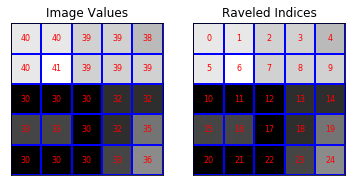

In [5]:
# raveled indices of the example image (for display purpose)
raveled_indices = np.arange(image.size).reshape(image.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3))

plot_img(ax1, image - image.min(), 'Image Values',
         plot_text=True, image_values=image)
plot_img(ax2, image - image.min(), 'Raveled Indices',
         plot_text=True, image_values=raveled_indices)
plt.show()

Visualizing threshold operations
================================
Now, we investigate the results of a series of threshold operations.
The max-tree hierarchy represents the inclusion relationship 
between the connected components at different levels (that is,
when applying an increasing threshold to the image).

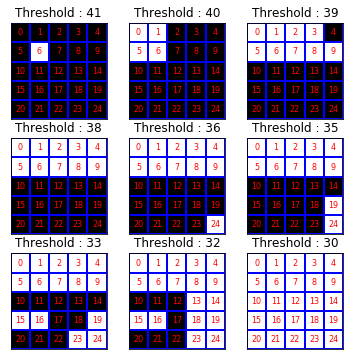

In [6]:
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6, 6))
thresholds = np.unique(image)
for k, threshold in enumerate(thresholds):
    bin_img = image >= threshold
    plot_img(axes[((8-k) // 3), ((8-k) % 3)], bin_img, 'Threshold : %i' % threshold,
             plot_text=True, image_values=raveled_indices)

Max-tree
========
Next, we calculate the max-tree of this image.

In [7]:
P, S = max_tree(image)

We display:

1. the **max-tree** of the image (note how white components show at the same level in the tree as in the thresholds above)
2. the **cannonical max-tree** is the internal representation of the max-tree:
    
    - each pixel at the same level of a single component points at the **cannonical element** of that component _(its parent)_ 
    - the parent of the cannonical element is a pixel in the component at the next level (whihc is also a cannonical element for its own component)



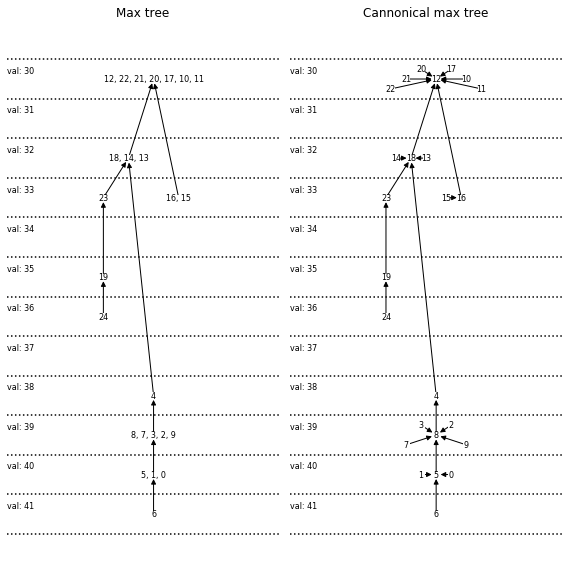

In [8]:
fig, (ax_mt, ax_ct) = plt.subplots(1, 2, sharey=True, figsize=(8, 8))

plot_max_tree(P, S, image, ax_mt, title = 'Max tree')
plot_max_tree(P, S, image, ax_ct, title = 'Cannonical max tree', cannonical = True)

fig.tight_layout()

We can also display this overlayed on the image. We plot the image again with the following overlays:
- the image intensity
- the parent relationship in the max-tree stored in `P`

The parent array `P` stores the **cannonical form** of the max-tree (above, right). It can be interpreted as a **max-tree** (above, left).

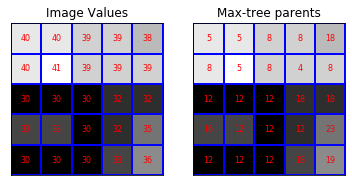

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3))

plot_img(ax1, image - image.min(), 'Image Values',
         plot_text=True, image_values=image)
plot_img(ax2, image - image.min(), 'Max-tree parents',
         plot_text=True, image_values=P)

Traversing the max-tree
==========

The tree traverser array `S` stores the **order of traversing** the pixels in the tree such that every pixel is preceeded by its parent. The (cannonical element of the) root, which has no parent, is the first element in this array.

It allows us to traverse the tree. We mark the image elements as we traverse the tree and display the image when we encounter a cannonical element ("when we complete" a **connected component** (node), we display it). **Compare** with the result of the threshold operation above.

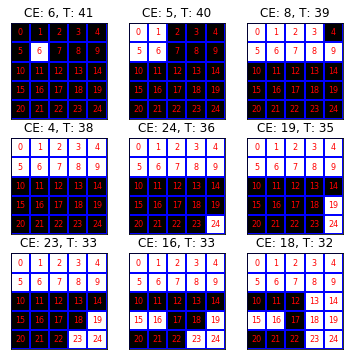

In [10]:
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6, 6))

#raveled image
image_rav = image.ravel()

#raveled parent
P_rav = P.ravel()

output_traversal = np.zeros(len(image_rav))
axis_index = 0
for pixel in S[::-1]:
    # we stop when we encounter root
    if pixel == S[0]:
        break
    output_traversal[pixel] = 1
    parent = P_rav[pixel]    
    parent_val = image_rav[parent]
    pixel_val = image_rav[pixel]
    # if cannonical element, display:
    if not image_rav[parent] == image_rav[pixel]:
        output_imshape = output_traversal.reshape(image.shape)
        plot_img(axes[(axis_index // 3), (axis_index % 3)], output_imshape,
                 'CE: {}, T: {}'.format(pixel, pixel_val),
                 plot_text=True, image_values=raveled_indices)
        axis_index += 1

Manipulating the max-tree: attribute filtering
=================

We can calculate and assign attributes to the nodes in the max-tree.
**Attributes** measure some properties of nodes in the tree (and
connected regions in general).

We can generally divide them into:

- **increasing (size) attributes**: as we traverse the tree from the leaves up, the value of these attributes striclty increases (same relation is true of any nested regions)

    _examples:_ area, diameter of axis-aligned bounding box, intensity range
    
    Filtering a tree with an increasing attribute always cuts off **all the nodes below a certain point** in a branch. Using an increasing attribute for attribute filtering defines an **attribute opening**.
    
    
- **non-increasing (shape, texture) attributes**: as we traverse the tree from the leaves up, there is no guarantee about the value of these attributes.

    _example:_ (non-)compactness, entropy of pixel values, Hu's moment invariants
    
    Filtering a tree with a shape attribute requries a choice of filtering strategy (as certain nodes might be removed but not their children). _This is out of the scope of this workshop_

Attribute opening
======

We display the original max-tree and show how attribute opening with different attributes affects both the tree and the image:

1. The max-tree of the image
2. Opening with area attribute (removing all nodes with area < `tr_area`)
3. Opening with diameter attribute (removing all nodes with diameter of axis-aligned bounding box < `tr_diameter`)
4. Opening with intensity attribute (removing all nodes with intensity range < `tr_intensity`)

**Note** that the parent array `P` is recalculated with each opening operation, but the tree traverser `S` remains valid after attribute opening operations.

_Change the attribute values and observe the effects on the filtered tree and image!_

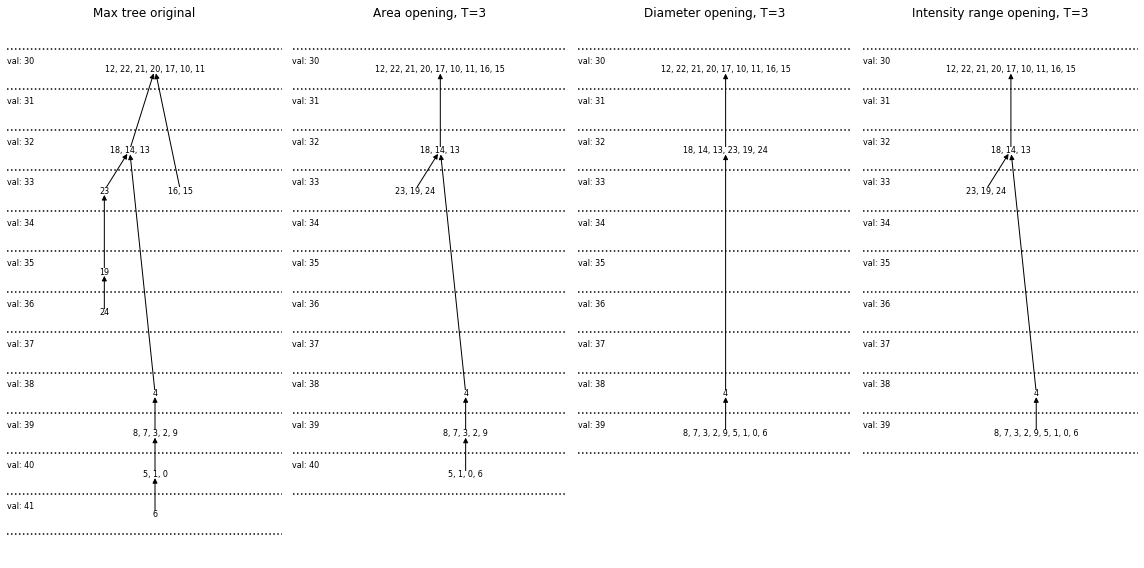

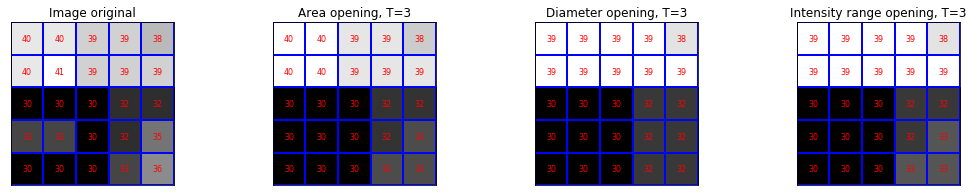

In [11]:
tr_area      = 3
tr_diameter  = 3
tr_intensity = 3

out_area,      P_area      = area_opening     (image, tr_area,      connectivity = 1,
                                               parent = P, tree_traverser = S)
out_diameter,  P_diameter  = diameter_opening (image, tr_diameter,  connectivity = 1,
                                               parent = P, tree_traverser = S)
out_intensity, P_intensity = intensity_opening(image, tr_intensity, connectivity = 1,
                                               parent = P, tree_traverser = S)

fig, (ax_mt, ax_a, ax_d, ax_i) = plt.subplots(1, 4, sharey=True, figsize=(16, 8))

plot_max_tree(P,           S, image,         ax_mt, title = 'Max tree original')
plot_max_tree(P_area,      S, out_area,      ax_a,  title = 'Area opening, T={}'.format(tr_area))
plot_max_tree(P_diameter,  S, out_diameter,  ax_d,  title = 'Diameter opening, T={}'.format(tr_diameter))
plot_max_tree(P_intensity, S, out_intensity, ax_i,  title = 'Intensity range opening, T={}'.format(tr_intensity))

fig.tight_layout()

plt.show()

fig, (ax_mt, ax_a, ax_d, ax_i) = plt.subplots(1, 4, sharey=True, figsize=(18, 3))

plot_img(ax_mt, image - image.min(),          'Image original',
            plot_text = True, image_values = image)
plot_img(ax_a,  out_area - image.min(),       'Area opening, T={}'.format(tr_area),
            plot_text = True, image_values = out_area)
plot_img(ax_d,  out_diameter - image.min(),   'Diameter opening, T={}'.format(tr_diameter),
            plot_text = True, image_values = out_diameter)
plot_img(ax_i,   out_intensity - image.min(), 'Intensity range opening, T={}'.format(tr_intensity),
            plot_text = True, image_values = out_intensity)
plt.show()


Chaining opening operations
======

Applying the smae opening operator with the threshold $T_2 > T_1$ has the effect of applying it with only $T_2$ (i.e. area opening with $T_1=3$ removes all componenst smaller than 3 pixels, then area opening with $T_2=8$ removes all componenst smaller than 8 pixels. This is the same as applying an area opening with $T=8$ directly.

The opening operations can be chained -- one type of opening applied to the result of another. Simply pass the **modified parent** array to the next opening call.

We display the _combinations_ of _area, diameter_ and _intensity_ openings.

**Question:** (If the same thresholds are used), is the result the same regardless of the order of operations?

**Answer:** 

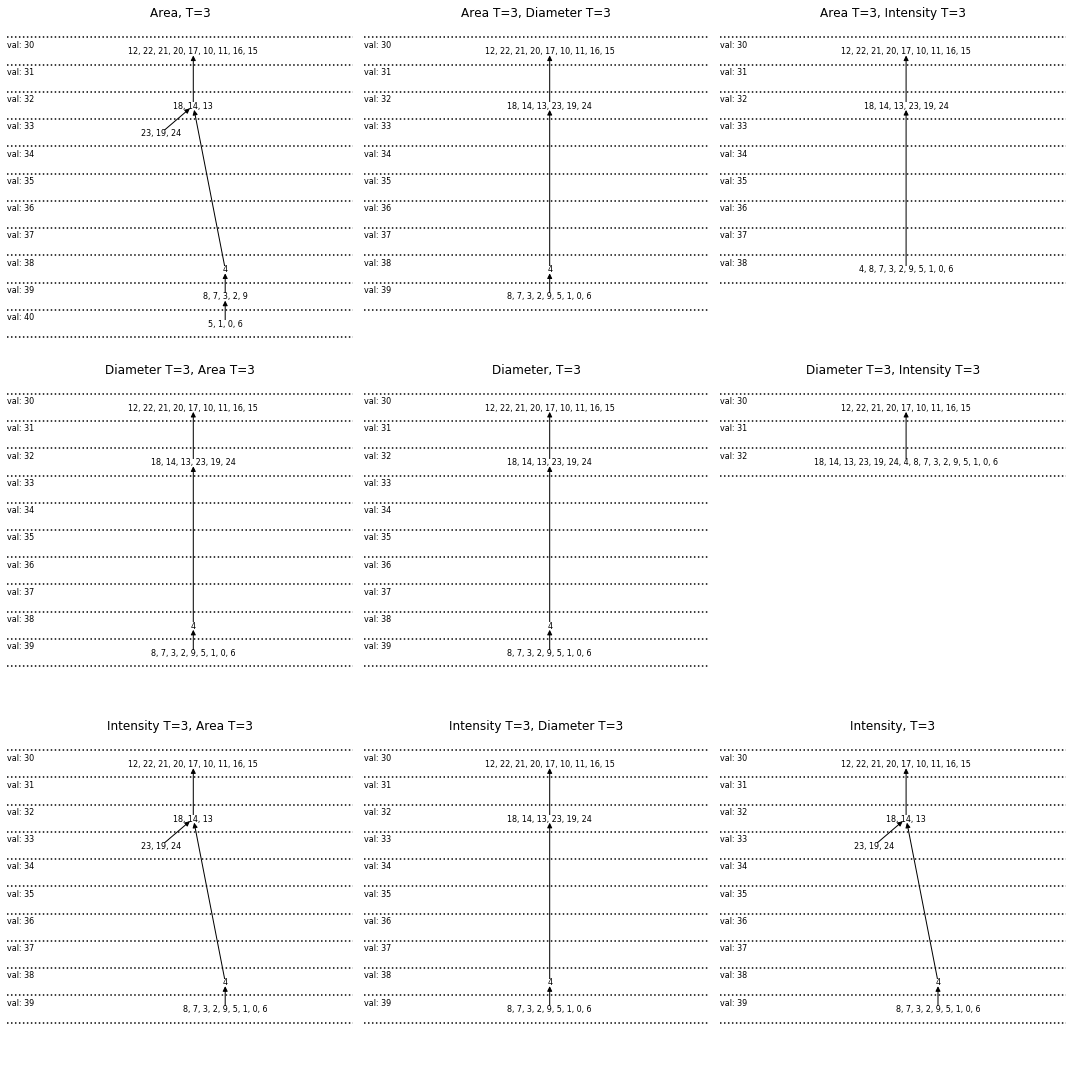

In [12]:
tr_a = 3
tr_d = 3
tr_i = 3

out_a, P_a = area_opening     (image, tr_a, connectivity = 1, parent = P, tree_traverser = S)
out_d, P_d = diameter_opening (image, tr_d, connectivity = 1, parent = P, tree_traverser = S)
out_i, P_i = intensity_opening(image, tr_i, connectivity = 1, parent = P, tree_traverser = S)

out_a_d, P_a_d = diameter_opening (out_a, tr_d, connectivity = 1, parent = P_a, tree_traverser = S)
out_a_i, P_a_i = intensity_opening(out_a, tr_i, connectivity = 1, parent = P_a, tree_traverser = S)
#out_a_i, P_a_i = intensity_opening(image, tr_i, connectivity = 1, parent = P_a, tree_traverser = S)
out_d_a, P_d_a = area_opening     (out_d, tr_a, connectivity = 1, parent = P_d, tree_traverser = S)
out_d_i, P_d_i = intensity_opening(out_d, tr_i, connectivity = 1, parent = P_d, tree_traverser = S)
#out_d_i, P_d_i = intensity_opening(image, tr_i, connectivity = 1, parent = P_d, tree_traverser = S)
out_i_a, P_i_a = area_opening     (out_i, tr_a, connectivity = 1, parent = P_i, tree_traverser = S)
out_i_d, P_i_d = diameter_opening (out_i, tr_d, connectivity = 1, parent = P_i, tree_traverser = S)

fig, axs = plt.subplots(3, 3, sharey=True, figsize=(15, 15))

plot_max_tree(P_a, S, out_a, axs[0][0], title = 'Area, T={}'.format(tr_a))
plot_max_tree(P_d, S, out_d, axs[1][1], title = 'Diameter, T={}'.format(tr_d))
plot_max_tree(P_i, S, out_i, axs[2][2], title = 'Intensity, T={}'.format(tr_i))

plot_max_tree(P_a_d, S, out_a_d, axs[0][1], title = 'Area T={}, Diameter T={}'.format(tr_a, tr_d))
plot_max_tree(P_a_i, S, out_a_i, axs[0][2], title = 'Area T={}, Intensity T={}'.format(tr_a, tr_i))

plot_max_tree(P_d_a, S, out_d_a, axs[1][0], title = 'Diameter T={}, Area T={}'.format(tr_d, tr_a))
plot_max_tree(P_d_i, S, out_d_i, axs[1][2], title = 'Diameter T={}, Intensity T={}'.format(tr_d, tr_i))

plot_max_tree(P_i_a, S, out_i_a, axs[2][0], title = 'Intensity T={}, Area T={}'.format(tr_i, tr_a))
plot_max_tree(P_i_d, S, out_i_d, axs[2][1], title = 'Intensity T={}, Diameter T={}'.format(tr_i, tr_d))

fig.tight_layout()

plt.show()


Using any attribute
=====

An **attribute opening** can be defined using any _increasing_ attribute. This can be achieved through calculating the attribute on the tree first, and then passing the already calculated attribute to the general `attribute_opening` function.

We define our own attributes `X_extent` and `Y_extent`. Instead of measuring the maximal diameter of the axis aligned bounding box (as in the function `diameter_opening`), it measures the extent along only one axis.

In [13]:
def X_extent(parent, tree_traverser):
    parent_rav = parent.ravel()
    imshape = parent.shape
    x_extent = np.ones(len(parent_rav))
    min_coord = np.unravel_index(np.arange(len(parent_rav)), imshape)[0]
    max_coord = np.unravel_index(np.arange(len(parent_rav)), imshape)[0]
    for p in tree_traverser[::-1]:
        if p == tree_traverser[0]:
            continue
        q = parent_rav[p]
        max_coord[q] = np.maximum(max_coord[q], max_coord[p])
        min_coord[q] = np.minimum(min_coord[q], min_coord[p])
        x_extent[q] = max_coord[q] - min_coord[q] + 1
        
    return x_extent

def Y_extent(parent, tree_traverser):
    parent_rav = parent.ravel()
    imshape = parent.shape
    y_extent = np.ones(len(parent_rav))
    min_coord = np.unravel_index(np.arange(len(parent_rav)), imshape)[1]
    max_coord = np.unravel_index(np.arange(len(parent_rav)), imshape)[1]
    for p in tree_traverser[::-1]:
        if p == tree_traverser[0]:
            continue
        q = parent_rav[p]
        max_coord[q] = np.maximum(max_coord[q], max_coord[p])
        min_coord[q] = np.minimum(min_coord[q], min_coord[p])
        y_extent[q] = max_coord[q] - min_coord[q] + 1
        
    return y_extent

The result of applying `X_extent` opening to the max-tree.

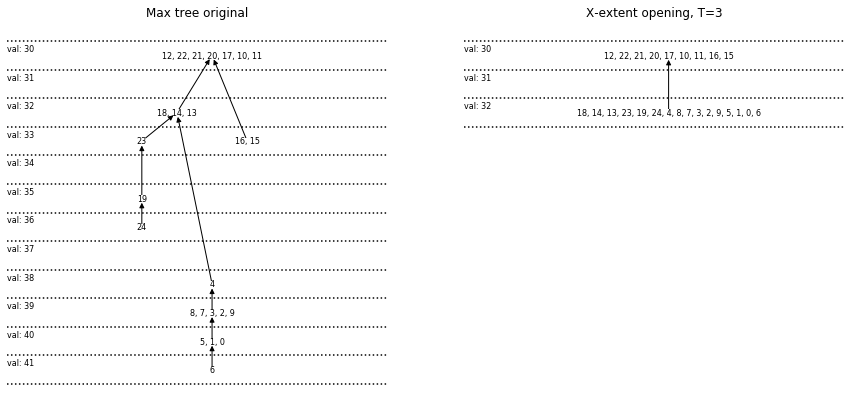

In [14]:
tr_xextent = 3

out_yextent, P_xextent = attribute_opening(image, X_extent(P, S), tr_xextent,
                                           connectivity = 1, parent = P, tree_traverser = S)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

plot_max_tree(P, S, image, ax1, title = 'Max tree original')
plot_max_tree(P_xextent, S, out_yextent, ax2, title = 'X-extent opening, T={}'.format(tr_xextent))

plt.show()

Examples on real images
======

Below are a colour and NIR (near infra-red) images of an onion patch with weeds collected in the fields of Lincolnshire in 2017.

Combining these two images, we can obtain the NDVI image (shown on the right). We will process this image with a max-tree (_detects bright objects on a dark background)._

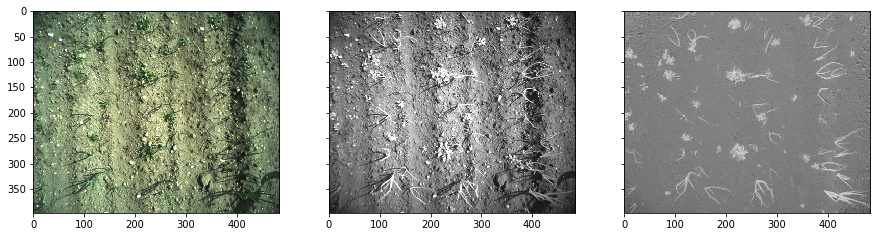

In [15]:
image_ndvi = io.imread('ndvi_small.png', as_gray=True)
image_rgbreg = io.imread('rgbreg_small.png', as_gray=False)
image_depth = io.imread('depth_small.png', as_gray=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 9))

rgbreg_plt = ax1.imshow(image_rgbreg)
depth_plt = ax2.imshow(image_depth, cmap='gray', vmin=0, vmax=65536)
ndvi_plt = ax3.imshow(image_ndvi, cmap='gray', vmin=0, vmax=255)

plt.show()

We create the max-tree:

In [16]:
P_ndvi, S_ndvi = max_tree(image_ndvi)

We can look for an area attribute that filters out **all the plants**.

That way, we can **segment the vegetation** from the image.

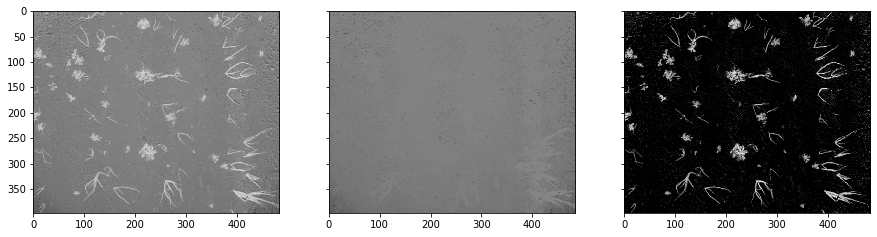

In [17]:
noplants, P_noplants = area_opening(image_ndvi, 3000, connectivity = 1, parent = P_ndvi, tree_traverser = S_ndvi)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
ax1.imshow(image_ndvi, cmap='gray', vmin=0, vmax=255)
ax2.imshow(noplants, cmap='gray', vmin=0, vmax=255)
ax3.imshow(image_ndvi-noplants, cmap='gray')
plt.show()

We can try to **select only specific plants.** For example, first we remove all the small plants. 

Then, we remove all the plants below a dertain diameter (observing that onions tend to be longer than weeds!)

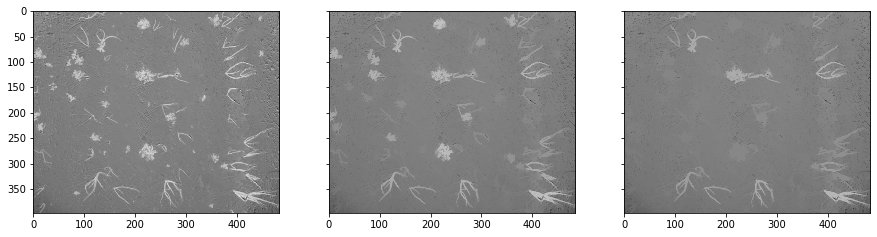

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 9))

ax1.imshow(image_ndvi, cmap='gray', vmin=0, vmax=255)
nosmall, P_nosmall = area_opening(image_ndvi, 150, connectivity = 1, parent = P_ndvi, tree_traverser = S_ndvi)
ax1.imshow(image_ndvi, cmap='gray', vmin=0, vmax=255)
#out_yextent, P_xextent = attribute_opening(nosmall, Y_extent(P_nosmall, S_ndvi), 40,
#                                           connectivity = 1, parent = P_nosmall, tree_traverser = S_ndvi)
noshort, P_noshort = diameter_opening(nosmall, 40, connectivity = 1, parent = P_nosmall, tree_traverser = S_ndvi)
ax2.imshow(nosmall, cmap='gray', vmin=0, vmax=255)
ax3.imshow(noshort, cmap='gray', vmin=0, vmax=255)
plt.show()